In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train_images_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-images.idx3-ubyte'
#train_labels_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-labels.idx1-ubyte'
#test_images_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-images.idx3-ubyte'
#test_labels_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-labels.idx1-ubyte

In [2]:
!pip install idx2numpy


  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=0935dc730972c8bb1577691d451563b8f47ccf0ef58be59963bf39a73ce1f256
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


Now we work on MLP Model 1

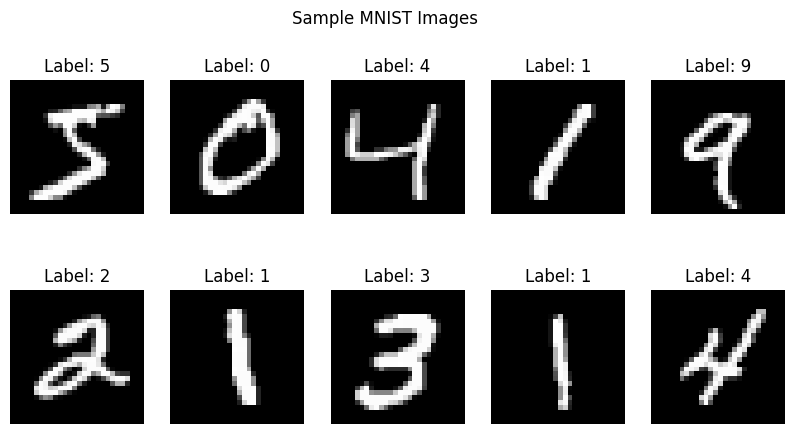

Epoch 0, Loss: 0.2582
Epoch 10, Loss: 0.0056
Epoch 20, Loss: 0.0010
Epoch 30, Loss: 0.0006
Epoch 40, Loss: 0.0004
Epoch 50, Loss: 0.0003
Epoch 60, Loss: 0.0003
Epoch 70, Loss: 0.0002
Epoch 80, Loss: 0.0002
Epoch 90, Loss: 0.0002
Epoch 100, Loss: 0.0002
Epoch 110, Loss: 0.0002
Epoch 120, Loss: 0.0001
Epoch 130, Loss: 0.0001
Epoch 140, Loss: 0.0001


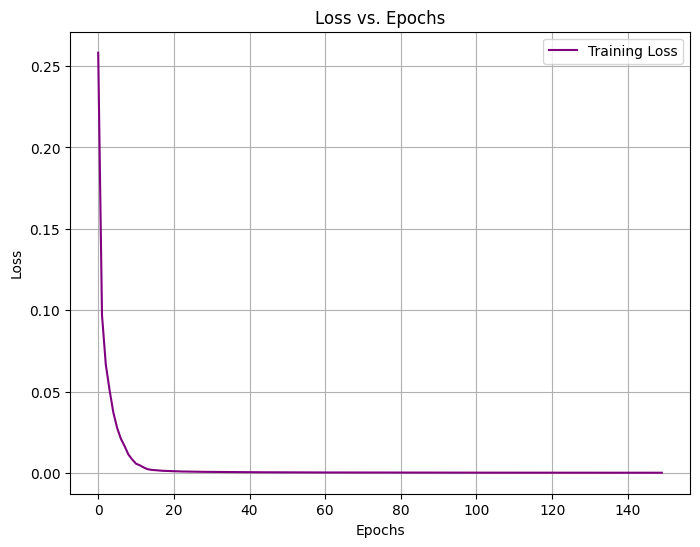

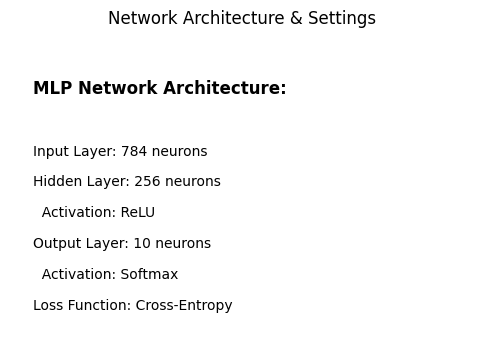

Confusion Matrix:
[[ 970    1    1    0    0    1    3    0    2    2]
 [   0 1127    2    1    0    0    2    1    2    0]
 [   2    2 1011    4    3    0    1    3    5    1]
 [   0    0    5  989    0    5    0    2    3    6]
 [   1    0    5    0  965    0    1    2    0    8]
 [   3    0    0    7    1  876    3    0    1    1]
 [   4    2    0    1    6    3  942    0    0    0]
 [   1    3    6    1    0    1    0 1008    2    6]
 [   2    0    2    6    1    1    3    2  953    4]
 [   3    2    0    5    6    2    0    6    2  983]]
Test Accuracy: 98.24%


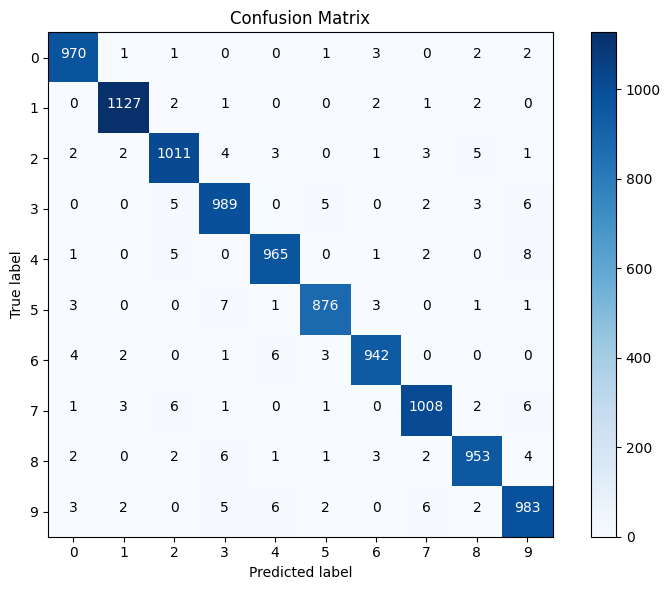

In [4]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

# This function grabs the images from an IDX file, flattens each 28x28 image into a 784-length vector, and normalizes the pixel values.
def load_mnist_images(filename):
    data = idx2numpy.convert_from_file(filename)
    return data.reshape(-1, 784) / 255.0

# This function reads the labels from an IDX file and converts them into a one-hot encoded format.
def load_mnist_labels(filename):
    data = idx2numpy.convert_from_file(filename)
    encoder = OneHotEncoder(sparse_output=False)
    return encoder.fit_transform(data.reshape(-1, 1))

# File paths pointing to the MNIST data stored on our Google Drive.
train_images_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-images.idx3-ubyte'
train_labels_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-labels.idx1-ubyte'
test_images_path  = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-images.idx3-ubyte'
test_labels_path  = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-labels.idx1-ubyte'

# Load our training and testing data.
x_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
x_test  = load_mnist_images(test_images_path)
y_test  = load_mnist_labels(test_labels_path)

# We want to peek at a few MNIST images to ensure things are working, so we display 10 samples in a grid.
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape(28, 28), cmap='gray')
    label = np.argmax(y_train[i])
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.suptitle("Sample MNIST Images")
plt.show()

# This class defines our simple MLP model with one hidden layer.
class MLP:
    # We set up our network parameters (input, hidden, and output sizes) and choose whether to use momentum.
    def __init__(self, input_size, hidden_size, output_size, use_momentum=True, momentum=0.9):
        self.use_momentum = use_momentum
        self.momentum = momentum

        # For the hidden layer, we use He initialization to match well with ReLU.
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        # For the output layer, Xavier initialization keeps things balanced for Softmax.
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        # If we're using momentum, we initialize our velocity terms to zero.
        if self.use_momentum:
            self.vW1 = np.zeros_like(self.W1)
            self.vb1 = np.zeros_like(self.b1)
            self.vW2 = np.zeros_like(self.W2)
            self.vb2 = np.zeros_like(self.b2)

    # This is our activation function for the hidden layer.
    def relu(self, x):
        return np.maximum(0, x)

    # Softmax turns our raw scores into probabilities for each digit.
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # This method runs the data through our network (forward pass).
    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    # Here we compute the gradients (backward pass) and update our weights, optionally using momentum.
    def backward(self, x, y, learning_rate):
        m = x.shape[0]
        dz2 = self.a2 - y
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 > 0)
        dw1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        if self.use_momentum:
            self.vW2 = self.momentum * self.vW2 - learning_rate * dw2
            self.vb2 = self.momentum * self.vb2 - learning_rate * db2
            self.vW1 = self.momentum * self.vW1 - learning_rate * dw1
            self.vb1 = self.momentum * self.vb1 - learning_rate * db1
            self.W2 += self.vW2
            self.b2 += self.vb2
            self.W1 += self.vW1
            self.b1 += self.vb1
        else:
            self.W2 -= learning_rate * dw2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dw1
            self.b1 -= learning_rate * db1

    # This method trains the network using mini-batches and gradually reduces the learning rate.
    def train(self, x, y, epochs, learning_rate, batch_size=128, lr_decay=0.99):
        losses = []
        n = x.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            for i in range(0, n, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                output = self.forward(x_batch)
                self.backward(x_batch, y_batch, learning_rate)
                loss = -np.sum(y_batch * np.log(output + 1e-8)) / x_batch.shape[0]
                epoch_loss += loss * x_batch.shape[0]
            epoch_loss /= n
            losses.append(epoch_loss)
            learning_rate *= lr_decay
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
        return losses

# Now we create our model and train it for 150 epochs.
mlp = MLP(input_size=784, hidden_size=256, output_size=10, use_momentum=True, momentum=0.9)
epochs = 150
initial_lr = 0.1
losses = mlp.train(x_train, y_train, epochs=epochs, learning_rate=initial_lr, batch_size=128, lr_decay=0.995)

# Let’s see how the loss changes over time.
plt.figure(figsize=(8,6))
plt.plot(range(len(losses)), losses, label="Training Loss", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

# A quick diagram to remind us of our network's layout.
plt.figure(figsize=(6,4))
plt.text(0.05, 0.8, "MLP Network Architecture:", fontsize=12, weight='bold')
plt.text(0.05, 0.6, "Input Layer: 784 neurons", fontsize=10)
plt.text(0.05, 0.5, "Hidden Layer: 256 neurons", fontsize=10)
plt.text(0.05, 0.4, "  Activation: ReLU", fontsize=10)
plt.text(0.05, 0.3, "Output Layer: 10 neurons", fontsize=10)
plt.text(0.05, 0.2, "  Activation: Softmax", fontsize=10)
plt.text(0.05, 0.1, "Loss Function: Cross-Entropy", fontsize=10)
plt.axis('off')
plt.title("Network Architecture & Settings", fontsize=12)
plt.show()

# Finally, we evaluate our model on the test data.
y_pred = mlp.forward(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# This function helps us visualize the confusion matrix in a more intuitive heatmap.
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])


Now we work on CNN Model 2

x_train shape: (60000, 28, 28, 1), y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1), y_test shape: (10000, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 71ms/step - accuracy: 0.8802 - loss: 0.3985 - val_accuracy: 0.9814 - val_loss: 0.0594
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accuracy: 0.9821 - loss: 0.0572 - val_accuracy: 0.9815 - val_loss: 0.0520
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.9875 - loss: 0.0389 - val_accuracy: 0.9882 - val_loss: 0.0375
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - accuracy: 0.9919 - loss: 0.0267 - val_accuracy: 0.9893 - val_loss: 0.0316
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.9935 - loss: 0.0218 - val_accuracy: 0.9888 - val_loss: 0.0320
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.9943 - loss: 0.0170 - val_accuracy: 0.9894 - val_loss: 0.0304
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 60ms/step - accuracy: 0.9958 - loss: 0.0126 - val_accuracy: 0.9905 - val_loss: 0.0269
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - accuracy: 0.9977 - loss: 0.0082 - 

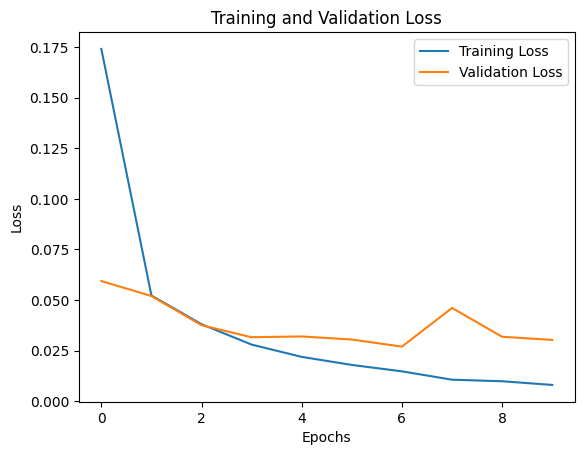

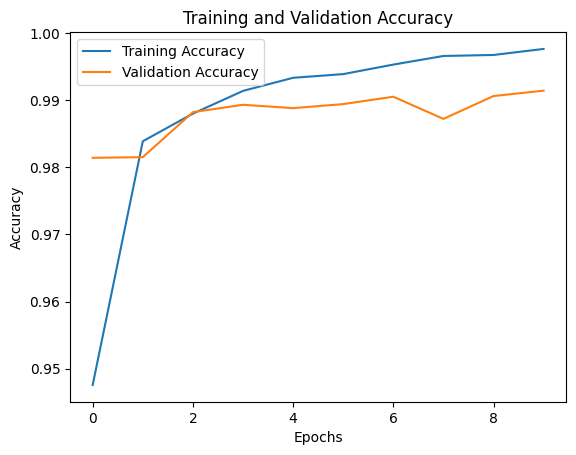

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

def load_mnist_images(filename):
    data = idx2numpy.convert_from_file(filename)
    return data.reshape(-1, 28, 28, 1) / 255.0
def load_mnist_labels(filename):
    data = idx2numpy.convert_from_file(filename)
    encoder = OneHotEncoder(sparse_output=False)
    return encoder.fit_transform(data.reshape(-1, 1))

train_images_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-images.idx3-ubyte'
train_labels_path = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/train-labels.idx1-ubyte'
test_images_path  = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-images.idx3-ubyte'
test_labels_path  = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-2/t10k-labels.idx1-ubyte'
x_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
x_test  = load_mnist_images(test_images_path)
y_test  = load_mnist_labels(test_labels_path)

# Print the shapes of our data arrays to verify that everything loaded correctly.
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Build a Convolutional Neural Network using the Keras Sequential API.
model = models.Sequential()

# Add a convolutional layer with 32 filters (3x3), ReLU activation, and specify the input shape.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Use max pooling to reduce spatial dimensions.
model.add(layers.MaxPooling2D((2, 2)))

# Add a second convolutional layer with 64 filters (3x3) and ReLU activation.
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Follow with another max pooling layer.
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to create a 1D feature vector.
model.add(layers.Flatten())
# Add a dense layer with 64 neurons and ReLU activation.
model.add(layers.Dense(64, activation='relu'))
# Add the final output layer with 10 neurons (for the 10 digit classes) and softmax activation.
model.add(layers.Dense(10, activation='softmax'))

# Print a summary of the model architecture.
model.summary()

# Compile the model using the Adam optimizer and categorical cross-entropy loss.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for 10 epochs with a batch size of 64, using the test set as validation data.
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_data=(x_test, y_test))

# Evaluate the model on the test set and print the test accuracy.
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict the classes on the test set.
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix and overall accuracy.
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion matrix:")
print(cm)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
